<a href="https://colab.research.google.com/github/ekourkchi/incNET-data/blob/master/VGG16_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
import os
import subprocess
from math import *
import numpy as np
from datetime import *
from pylab import *
import matplotlib as mpl
from matplotlib.widgets import Slider, Button, RadioButtons
import matplotlib.pyplot as plt
from astropy.table import Table, Column 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import scipy.misc as scimisc
import random
from sklearn.model_selection import train_test_split

# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
data = np.load('/content/drive/My Drive/data_64x64.npz')
images_ = data['images']
labels_ = data['labels'] 
data.close() 

In [3]:
ix, = np.where(labels_[1]>50)

images_c = images_[ix]
labels_c = labels_[1][ix]
pgcIDs_c = labels_[0][ix]

images_train, images_test, labels_train, labels_test, pgcIDs_train,  pgcIDs_test = train_test_split(images_c, labels_c, pgcIDs_c, test_size=0.40)

notUnique = np.isin(pgcIDs_test, pgcIDs_train)
Unique = np.logical_not(notUnique)

images_train = np.concatenate((images_train, images_test[notUnique]))
labels_train  = np.concatenate((labels_train, labels_test[notUnique]))
pgcIDs_train = np.concatenate((pgcIDs_train, pgcIDs_test[notUnique]))

images_test = images_test[Unique]
labels_test = labels_test[Unique]
pgcIDs_test = pgcIDs_test[Unique]


In [4]:
print(images_train.shape)
print(images_test.shape)
print(labels_train.shape)
print(labels_test.shape)
print(pgcIDs_train.shape)
print(pgcIDs_test.shape)

(41964, 64, 64, 3)
(1060, 64, 64, 3)
(41964,)
(1060,)
(41964,)
(1060,)


In [5]:
labels_train  = labels_train - 51
labels_test   = labels_test - 51
images_test   = images_test / 255.
images_train  = images_train / 255.

In [6]:
from keras.applications.resnet50 import ResNet50
from keras import applications

from keras.models import Model
import keras

resnet = applications.VGG16(include_top=False, weights='imagenet', input_shape=(64, 64, 3))
resnet.trainable = True

for layer in resnet.layers[:-8]:
    layer.trainable = False

In [7]:
import pandas as pd
layers = [(layer, layer.name, layer.trainable) for layer in resnet.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']).tail(10)

,Layer Type,Layer Name,Layer Trainable
9,<tensorflow.python.keras.layers.convolutional....,block3_conv3,False
10,<tensorflow.python.keras.layers.pooling.MaxPoo...,block3_pool,False
11,<tensorflow.python.keras.layers.convolutional....,block4_conv1,True
12,<tensorflow.python.keras.layers.convolutional....,block4_conv2,True
13,<tensorflow.python.keras.layers.convolutional....,block4_conv3,True
14,<tensorflow.python.keras.layers.pooling.MaxPoo...,block4_pool,True
15,<tensorflow.python.keras.layers.convolutional....,block5_conv1,True
16,<tensorflow.python.keras.layers.convolutional....,block5_conv2,True
17,<tensorflow.python.keras.layers.convolutional....,block5_conv3,True
18,<tensorflow.python.keras.layers.pooling.MaxPoo...,block5_pool,True


In [8]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, BatchNormalization
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(resnet)

# model.add(Conv2D(512, (1, 1), activation='relu'))
# model.add(BatchNormalization(axis = 3))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.20))

model.add(Flatten())


model.add(Dense(512, activation='relu'))
model.add(Dropout(0.30))
# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
# model.add(Dense(80, activation='relu'))
# model.add(Dropout(0.25))
model.add(Dense(40, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 40)                5

In [9]:
import keras.backend as K

def custom_loss(y_true, y_pred):

    # yt = K.argmax(y_true, axis = 1 )
    yt = y_true
    yp = K.argmax(y_pred, axis = 1 )
  
    yt = K.cast(yt, dtype='float64')
    yp = K.cast(yp, dtype='float64')

    # calculate loss, using y_pred
    loss = K.square(yp - yt)

    # summing both loss values along batch dimension 
    loss = K.mean(loss, -1)        # (batch_size,)
        
    return  K.sqrt(loss)

model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy', custom_loss])
n_epochs = 20
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 40)                5

In [10]:
model_history = model.fit(images_train, labels_train, 
                                  epochs=n_epochs, batch_size=512, verbose=2, 
                                  validation_data=(images_test, labels_test),
                                  shuffle=True)

Epoch 1/20
82/82 - 12s - loss: 3.3504 - accuracy: 0.0682 - custom_loss: 3.5231 - val_loss: 2.6557 - val_accuracy: 0.1528 - val_custom_loss: 3.6093
Epoch 2/20
82/82 - 10s - loss: 2.5914 - accuracy: 0.1578 - custom_loss: 3.5889 - val_loss: 2.3565 - val_accuracy: 0.1538 - val_custom_loss: 3.6009
Epoch 3/20
82/82 - 10s - loss: 2.3847 - accuracy: 0.1856 - custom_loss: 3.5749 - val_loss: 2.2704 - val_accuracy: 0.2283 - val_custom_loss: 3.5917
Epoch 4/20
82/82 - 10s - loss: 2.2988 - accuracy: 0.1961 - custom_loss: 3.5731 - val_loss: 2.2193 - val_accuracy: 0.2198 - val_custom_loss: 3.5882
Epoch 5/20
82/82 - 10s - loss: 2.2309 - accuracy: 0.2116 - custom_loss: 3.5734 - val_loss: 2.2019 - val_accuracy: 0.2245 - val_custom_loss: 3.5466
Epoch 6/20
82/82 - 10s - loss: 2.1739 - accuracy: 0.2192 - custom_loss: 3.5740 - val_loss: 2.1765 - val_accuracy: 0.2340 - val_custom_loss: 3.6201
Epoch 7/20
82/82 - 10s - loss: 2.1473 - accuracy: 0.2230 - custom_loss: 3.5745 - val_loss: 2.0804 - val_accuracy: 0.25

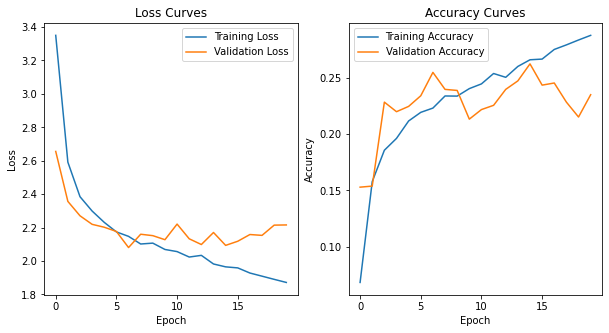

In [15]:
def plot_model_history(history):
    '''Plot the training and validation history for a TensorFlow network'''

    # Extract loss and accuracy
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5))
    ax[0].plot(np.arange(n_epochs), loss, label='Training Loss')
    ax[0].plot(np.arange(n_epochs), val_loss, label='Validation Loss')
    ax[0].set_title('Loss Curves')
    ax[0].legend()
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(np.arange(n_epochs), acc, label='Training Accuracy')
    ax[1].plot(np.arange(n_epochs), val_acc, label='Validation Accuracy')
    ax[1].set_title('Accuracy Curves')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    
# plot the training history
# print vgg_model.history.history['loss']

plot_model_history(model_history)
  

In [16]:
inc_p = model.predict(images_test)
inc_m = labels_test +51


N = images_test.shape[0]

inc_p = np.argmax(inc_p, axis=1) + 51

2.838914222420986
2.7635973521687496


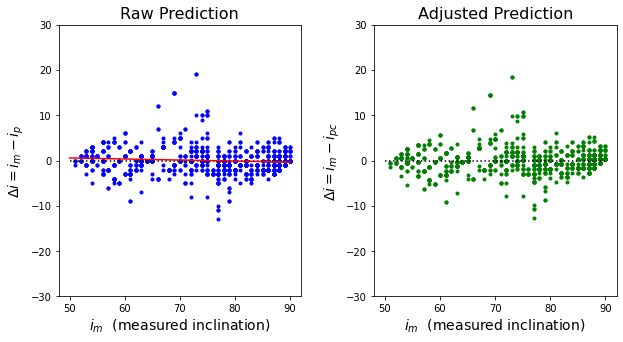

In [17]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5)) 

d = inc_m-inc_p

m, b = np.polyfit(inc_m, d, 1)
x = np.linspace(50,90,20)
y  = m*x+b

ax[0].plot(inc_m, d, 'b.')
ax[0].plot([50,90],[0,0], 'k:')
ax[0].plot(x, y, 'r-')
ax[0].set_xlim(48,92)
ax[0].set_ylim(-30,30)
ax[0].set_title('Raw Prediction', fontsize=16)
ax[0].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[0].set_ylabel(r'$\Delta i = i_m-i_p$', fontsize=14)

print(np.sqrt(np.mean((d)**2)))


d_ = inc_m-(inc_p+b)/(1.-m)
ax[1].plot(inc_m, d_, 'g.')
ax[1].plot([50,90],[0,0], 'k:')
ax[1].set_xlim(48,92)
ax[1].set_ylim(-30,30)

print(np.sqrt(np.mean((d_)**2)))
ax[1].set_title('Adjusted Prediction', fontsize=16)
ax[1].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[1].set_ylabel(r'$\Delta i = i_m-i_{pc}$', fontsize=14)

plt.subplots_adjust( wspace=0.3)

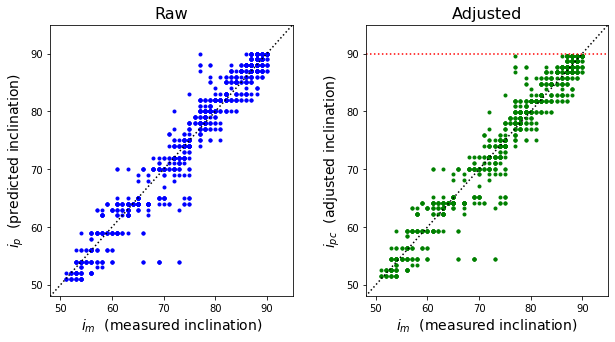

In [18]:
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(10,5)) 

ax[0].plot(inc_m, inc_p, 'b.')
ax[0].plot([48,95],[48,95], 'k:')
ax[0].set_xlim(48,95)
ax[0].set_ylim(48,95)
ax[0].set_title('Raw', fontsize=16)
ax[0].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[0].set_ylabel(r'$i_p$'+'  (predicted inclination)', fontsize=14)

ax[1].plot(inc_m, (inc_p+b)/(1.-m), 'g.')
ax[1].plot([48,95],[48,95], 'k:')
ax[1].set_xlim(48,95)
ax[1].set_ylim(48,95)
ax[1].plot([48,95],[90,90], 'r:')
ax[1].set_title('Adjusted', fontsize=16)
ax[1].set_xlabel(r'$i_m$'+'  (measured inclination)', fontsize=14)
ax[1].set_ylabel(r'$i_{pc}$'+'  (adjusted inclination)', fontsize=14)

plt.subplots_adjust( wspace=0.3)